<a href="https://colab.research.google.com/github/yohanesnuwara/computational-geophysics/blob/master/gravity/AnomalySeparation_1D_FFT_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy
from scipy.interpolate import griddata
from scipy.optimize import curve_fit

In [2]:
!git clone https://www.github.com/yohanesnuwara/computational-geophysics

Cloning into 'computational-geophysics'...
remote: Enumerating objects: 544, done.
remote: Counting objects: 100% (307/307), done.
remote: Compressing objects: 100% (305/305), done.
remote: Total 544 (delta 196), reused 0 (delta 0), pack-reused 237
Receiving objects: 100% (544/544), 42.21 MiB | 21.42 MiB/s, done.
Resolving deltas: 100% (317/317), done.


Data from Roosevelt Hot Springs, USA. Source: Geothermal Data Repository OpenEi

In [3]:
data = np.loadtxt('/content/computational-geophysics/gravity/data/Gravity_UTM.txt')
utm_x = np.array(data[:,0])
utm_y = np.array(data[:,1])
CBA = np.array(data[:,2])

Grid map with no interpolation.

In [4]:
xi = np.linspace(min(utm_x), max(utm_x), 50)
yi = np.linspace(min(utm_y), max(utm_y), 50)
xi, yi = np.meshgrid(xi, yi)

# Interpolation
zi = griddata((utm_x,utm_y),CBA,(xi,yi))

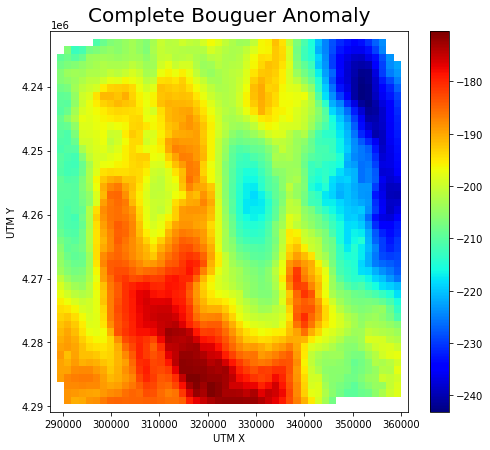

In [5]:
# Min max coordinates
xmin, xmax = min(utm_x), max(utm_x)
ymin, ymax = min(utm_y), max(utm_y)

plt.figure(figsize=(8,7))

plt.imshow(zi, aspect='auto', extent=(xmin,xmax,ymax,ymin), cmap='jet')
plt.title("Complete Bouguer Anomaly", size=20, pad=10)
plt.xlabel("UTM X"); plt.ylabel("UTM Y")
plt.colorbar()

plt.show()

Contour map with cubic interpolation.

In [6]:
xi = np.linspace(min(utm_x), max(utm_x), 50)
yi = np.linspace(min(utm_y), max(utm_y), 50)
xi, yi = np.meshgrid(xi, yi)

# Interpolation
zi = griddata((utm_x,utm_y),CBA,(xi,yi), method='cubic')

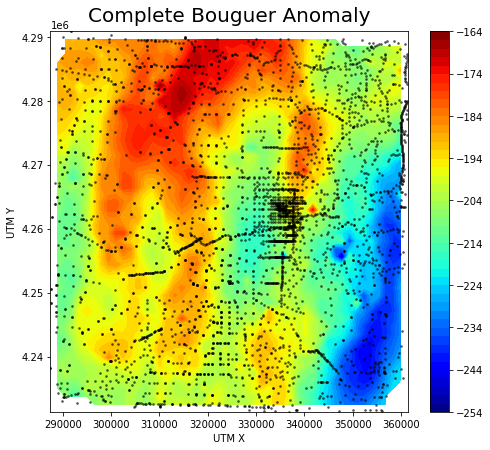

In [7]:
plt.figure(figsize=(8,7))

# Plot CBA contours
plt.contourf(xi, yi, zi, levels=50, cmap="jet")
plt.colorbar()
plt.title('Complete Bouguer Anomaly', size=20, pad=10)
plt.xlabel('UTM X'); plt.ylabel('UTM Y')

# Plot stations
plt.scatter(utm_x, utm_y, s=3, color='black', alpha=0.5)

plt.show()

Create 2D slices.

In [8]:
def makeSlice(xi, yi, zi, orientation='EW', loc=10):
  if orientation=='EW':
    # E-W slice
    x_slice = xi[loc]
    y_slice = yi[loc]
    g_slice = zi[loc]

  if orientation=='NS':
    x_slice = []
    for k in range(len(xi)):
      xslice = xi[k][loc]
      x_slice.append(float(xslice))
    x_slice = np.array(x_slice)

    y_slice = []
    for k in range(len(xi)):
      yslice = yi[k][k]
      y_slice.append(float(yslice))
    y_slice = np.array(y_slice)

    g_slice = []
    for k in range(len(xi)):
      gslice = zi[k][loc]
      g_slice.append(float(gslice))
    g_slice = np.array(g_slice)

  if orientation=='SWNE':
    # SW-NE slice
    x_slice = np.array(xi[0])

    y_slice = []
    for k in range(len(x_slice)):
      yslice = yi[k][k]
      y_slice.append(float(yslice))
    y_slice = np.array(y_slice)

    g_slice = []
    for k in range(len(x_slice)):
      gslice = zi[k][k]
      g_slice.append(float(gslice))
    g_slice = np.array(g_slice) 

  if orientation=='SENW':
    # SE-NW slice
    x_slice = np.array(xi[0])

    y_slice = []
    for k, j in zip(reversed(range(len(x_slice))), (range(len(x_slice)))):
      yslice = yi[k][j]
      y_slice.append(float(yslice))
    y_slice = np.array(y_slice)

    g_slice = []
    for k, j in zip(reversed(range(len(x_slice))), (range(len(x_slice)))):
      gslice = zi[k][j]
      g_slice.append(float(gslice))
    g_slice = np.array(g_slice)

  return x_slice, y_slice, g_slice

In [9]:
# Make 2D slices
SWNE = makeSlice(xi, yi, zi, orientation='SWNE')
SENW = makeSlice(xi, yi, zi, orientation='SENW')
EW1 = makeSlice(xi, yi, zi, orientation='EW', loc=10)
EW2 = makeSlice(xi, yi, zi, orientation='EW', loc=zi.shape[0]//2) # Centre
EW3 = makeSlice(xi, yi, zi, orientation='EW', loc=40)

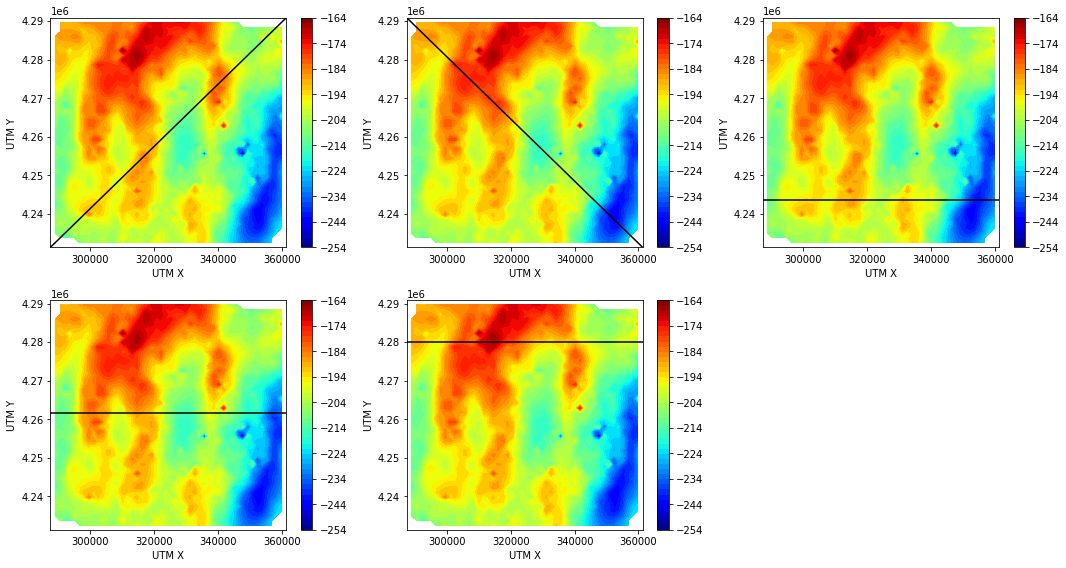

In [10]:
# Plot lines on grid map
data = [SWNE, SENW, EW1, EW2, EW3]

plt.figure(figsize=(15,8))

for i in range(5):
  plt.subplot(2,3,i+1)
  plt.contourf(xi, yi, zi, levels=50, cmap="jet")
  plt.plot(data[i][0], data[i][1], color='black')
  plt.xlabel("UTM X"); plt.ylabel("UTM Y")
  plt.colorbar()

plt.tight_layout(1.1)
plt.show()

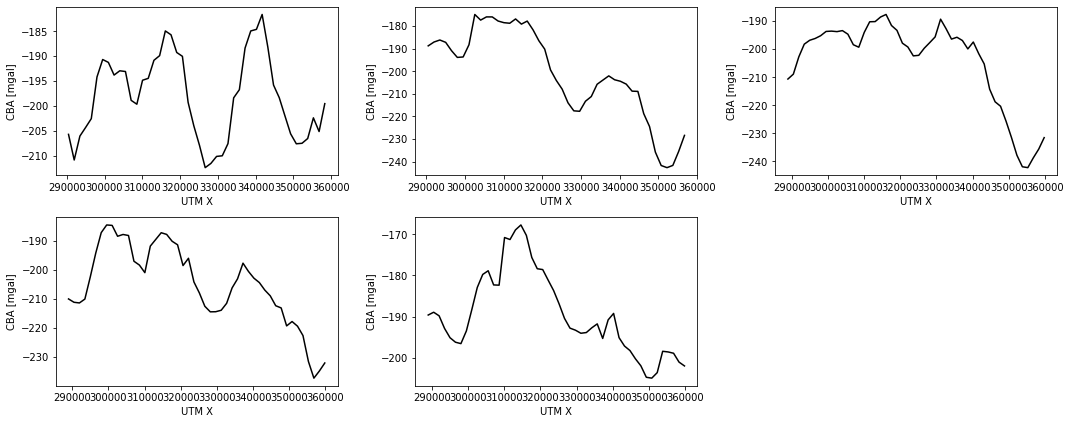

In [11]:
# Plot CBA over UTM X
data = [SWNE, SENW, EW1, EW2, EW3]

plt.figure(figsize=(15,6))

for i in range(5):
  plt.subplot(2,3,i+1)
  plt.plot(data[i][0], data[i][2], color='black')
  plt.xlabel("UTM X"); plt.ylabel("CBA [mgal]")

plt.tight_layout(1.1)
plt.show()

Transform (UTM X, UTM Y) of slice to Distances, so we have CBA profile over Distance.

In [12]:
def distanceAxis(slice):
  x_slice, y_slice, g_slice = slice
  xd, yd = np.diff(x_slice)**2, np.diff(y_slice)**2
  d = np.sqrt(xd + yd)
  d = np.append(0, np.cumsum(d))
  return d, g_slice

In [13]:
# Transform (x,y,slice) to (distance,slice)
SWNE_t = distanceAxis(SWNE)
SENW_t = distanceAxis(SENW)
EW1_t = distanceAxis(EW1)
EW2_t = distanceAxis(EW2)
EW3_t = distanceAxis(EW3)

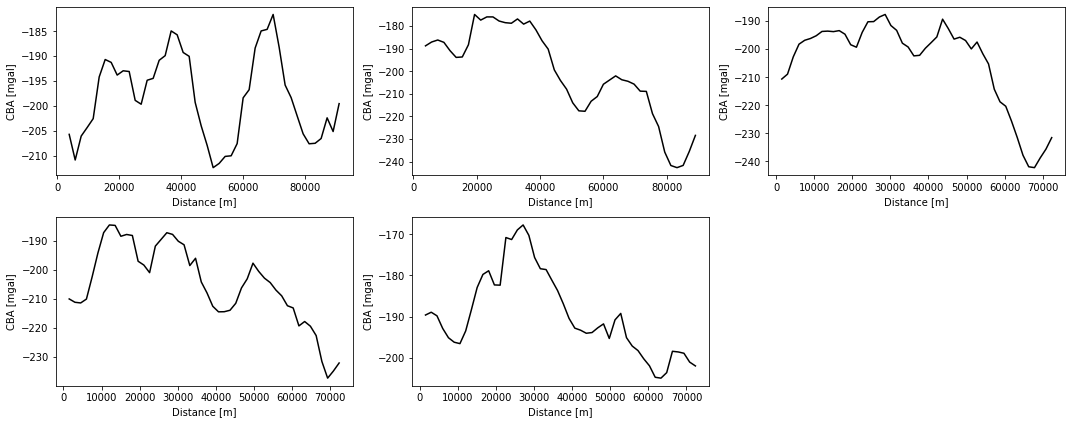

In [14]:
# Plot CBA over Distance
data = [SWNE_t, SENW_t, EW1_t, EW2_t, EW3_t]

plt.figure(figsize=(15,6))

for i in range(5):
  plt.subplot(2,3,i+1)
  plt.plot(data[i][0], data[i][1], color='black')
  plt.xlabel("Distance [m]"); plt.ylabel("CBA [mgal]")

plt.tight_layout(1.1)
plt.show()

In [15]:
def createDataframe(slice):
  x_slice, y_slice, g_slice = slice
  d, g_slice = distanceAxis(slice)
  # Drop NaN values
  return pd.DataFrame({'UTM X': x_slice, 'UTM Y': y_slice,
                       'Distance': d, 'CBA': g_slice}).dropna().reset_index(drop=True)

In [16]:
# Make dataframe
SWNE_df = createDataframe(SWNE)
SENW_df = createDataframe(SENW)
EW1_df = createDataframe(EW1)
EW2_df = createDataframe(EW2)
EW3_df = createDataframe(EW3)

EW1_df.head(10)

,UTM X,UTM Y,Distance,CBA
0,288964.640341,4.243502e+06,1507.455641,-210.684510
1,290472.095982,4.243502e+06,3014.911282,-208.941836
2,291979.551622,4.243502e+06,4522.366922,-202.793251
3,293487.007263,4.243502e+06,6029.822563,-198.273014
4,294994.462904,4.243502e+06,7537.278204,-196.881126
5,296501.918545,4.243502e+06,9044.733845,-196.246887
6,298009.374186,4.243502e+06,10552.189486,-195.270077
7,299516.829827,4.243502e+06,12059.645127,-193.743529
8,301024.285467,4.243502e+06,13567.100767,-193.627887
9,302531.741108,4.243502e+06,15074.556408,-193.808854


1D Fast Fourier Transform to calculate anomaly spectrum.

In [17]:
def dft(x):
  # Discrete Fourier transform
  x = np.asarray(x, dtype=float)
  N = x.shape[0]
  n = np.arange(N)
  k = n.reshape((N, 1))
  M = np.exp(-2j * np.pi * k * n / N)
  fourier = np.dot(M, x)

  # Decompose complex number into imag and real components
  imaginary = fourier.imag
  real = fourier.real
  absolute = np.sqrt((imaginary**2) + (real**2))
  ln_abs = np.log(absolute)
  return ln_abs

def spectral1DFFT(slice_df):
  """
  Calculate Spectrum of Gravity Anomaly from 1D FFT

  INPUT: 
  
  slice_df: CBA slice (in DataFrame)

  OUTPUT:

  k: Wavenumber
  lnAbs: Logarithm of absolute component of 1D FFT result
  """
  # distance, g_slice = slice
  distance, g_slice = slice_df.Distance.values, slice_df.CBA.values

  # Calculate logarithmic of absolute component by 1D FFT
  lnAbs = dft(g_slice)

  # Calculate sampling frequency and wavenumber
  interval_last = distance[-1]
  minus = interval_last - distance[0]

  f_s = 0 # initial freq sampling
  f_sample = []

  for i in range(0,len(g_slice)-1):
    f_s = f_s + (1 / minus)
    f_sample.append(float(f_s))
  f_sample = np.append(0, f_sample) 

  # Calculate wavenumber
  k = 2 * np.pi * f_sample

  return k, lnAbs

In [18]:
# 1D FFT and calculate spectrum
SWNE_fft = spectral1DFFT(SWNE_df)
SENW_fft = spectral1DFFT(SENW_df)
EW1_fft = spectral1DFFT(EW1_df)
EW2_fft = spectral1DFFT(EW2_df)
EW3_fft = spectral1DFFT(EW3_df)

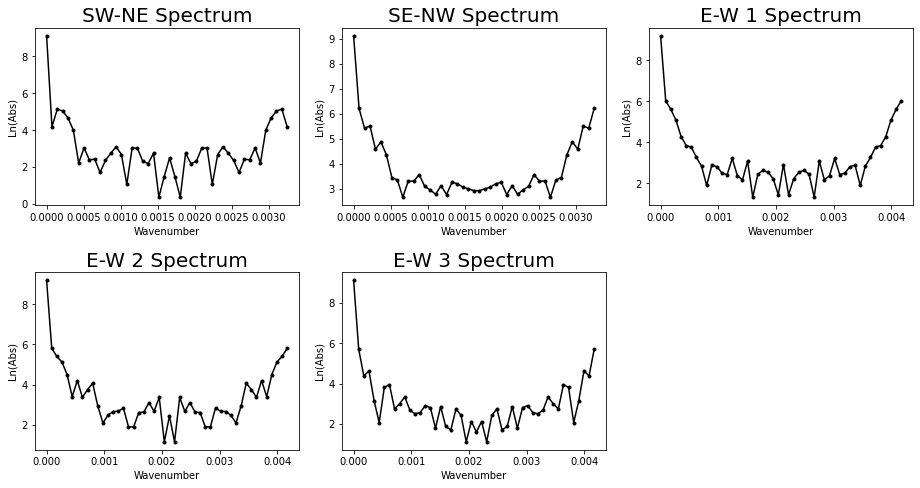

In [19]:
fft = [SWNE_fft, SENW_fft, EW1_fft, EW2_fft, EW3_fft]
fft_title = ['SW-NE', 'SE-NW', 'E-W 1', 'E-W 2', 'E-W 3']

plt.figure(figsize=(13,7))
for i in range(len(fft)):
  plt.subplot(2,3,i+1)
  plt.plot(fft[i][0], fft[i][1], '.-', color='black')
  plt.xlabel("Wavenumber"); plt.ylabel("Ln(Abs)")
  plt.title("{} Spectrum".format(fft_title[i]), size=20)

plt.tight_layout(1.5)
plt.show()

Specify regional and residual anomaly cut-off on the spectrum and calculate rolling window.

In [20]:
def selectWindow(window):
  """
  Window must be an odd number. Rule and example:

  * 1.25 rounded to 1. 1 is odd, so window = 1
  * 1.75 rounded to 2. 2 is even, so window = 2 - 1 = 1
  * 2.25 rounded to 2. 2 is even, so window = 2 + 1 = 3
  * 2.75 rounded to 3. 3 is even, so window = 3
  """
  rounded = np.round(window)

  if rounded % 2 == 0:
    # even
    if (rounded - window) > 0:
      window = rounded - 1
    if (rounded - window) < 0:
      window = rounded + 1
  else:
    # odd
    window = rounded  
  return int(window)

def analyzeSpectral(slice_df, k, lnAbs, reg_cut=2, res_cut=6):
  # Regional cutoff
  k_reg_cut = k[:reg_cut] 
  ln_reg_cut = lnAbs[:reg_cut]

  # Residual cutoff
  k_res_cut = k[reg_cut:res_cut] 
  ln_res_cut = lnAbs[reg_cut:res_cut]
  
  # Noise cutoff
  k_noise_cut = k[res_cut:]
  ln_noise_cut = lnAbs[res_cut:]

  # Linear regression
  def linear(x, a, b):
    return a*x+b
  
  [a_reg, b_reg], _ = curve_fit(linear, k_reg_cut, ln_reg_cut)
  [a_res, b_res], _ = curve_fit(linear, k_res_cut, ln_res_cut)
  [a_noise, b_noise], _ = curve_fit(linear, k_noise_cut, ln_noise_cut)
  print("Regional slope: {:.3f}".format(a_reg))
  print("Residual slope: {:.3f}".format(a_res))

  ln_reg_fit = linear(k_reg_cut, a_reg, b_reg)
  ln_res_fit = linear(k_res_cut, a_res, b_res)
  ln_noise_fit = linear(k_noise_cut, a_noise, b_noise)

  # Calculate cutoff frequency
  cut_off = (b_res - b_reg) / (a_reg - a_res)
  print("Cut-off Frequency: {:.5f}".format(cut_off))

  # Calculate window
  distance = slice_df.Distance.values
  window = 2*np.pi/((distance[3]-distance[2])*cut_off)  
  window = selectWindow(window) # windowing rule
  print("Calculated window: {} \n".format(window))  

  # Plot spectrum and regressed lines
  plt.figure(figsize=(7,5))
  plt.scatter(k, lnAbs, c='black', alpha=0.7)

  plt.plot(k_reg_cut, ln_reg_cut, color='red') 
  plt.plot(k_reg_cut, ln_reg_fit, '--', color='red', label='Regional')

  plt.plot(k_res_cut, ln_res_cut, color='green') 
  plt.plot(k_res_cut, ln_res_fit, '--', color='green', label='Residual')

  plt.plot(k_noise_cut, ln_noise_cut, color='orange') 
  plt.plot(k_noise_cut, ln_noise_fit, '--', color='orange', label='Noise')  
  
  plt.axvline(cut_off, color='blue', linewidth=1, label='Cut-off')
  plt.title("Anomaly Spectrum", size=20, pad=10)
  plt.xlabel("Wavenumber, k"); plt.ylabel("ln(Abs)")

  plt.legend()
  plt.show()

  return cut_off, window

Regional slope: -11168.456
Residual slope: -4123.557
Cut-off Frequency: 0.00033
Calculated window: 9 



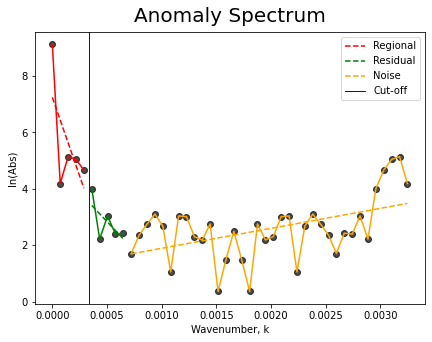

Regional slope: -13229.530
Residual slope: -2506.976
Cut-off Frequency: 0.00027
Calculated window: 11 



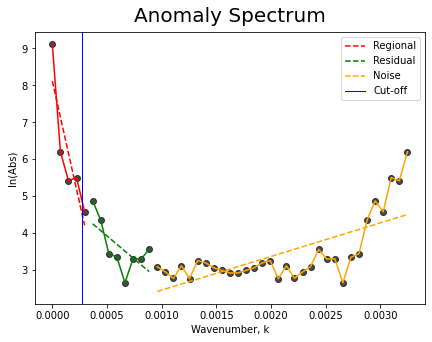

Regional slope: -12141.413
Residual slope: -2507.225
Cut-off Frequency: 0.00035
Calculated window: 11 



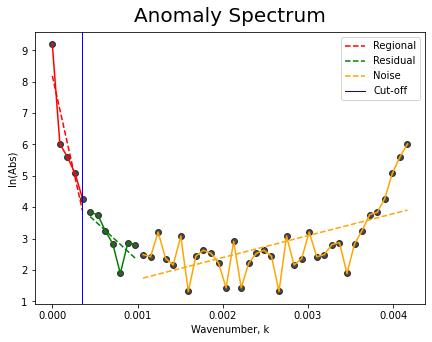

Regional slope: -11357.650
Residual slope: -2321.730
Cut-off Frequency: 0.00033
Calculated window: 13 



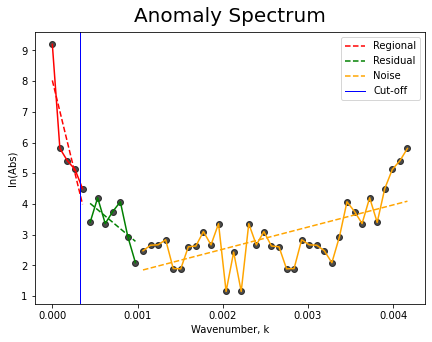

Regional slope: -14652.657
Residual slope: -727.670
Cut-off Frequency: 0.00032
Calculated window: 13 



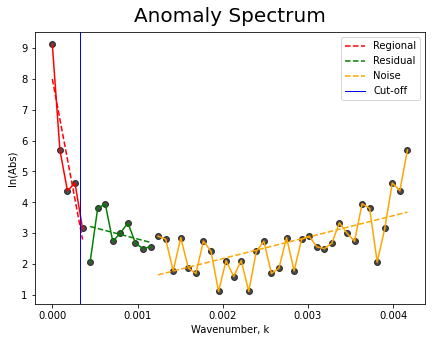

In [21]:
# Analyze spectrum of each slice. Specify reg_cut and res_cut.
SWNE_cutoff, SWNE_window = analyzeSpectral(SWNE_df, SWNE_fft[0], SWNE_fft[1], reg_cut=5, res_cut=10)
SENW_cutoff, SENW_window = analyzeSpectral(SENW_df, SENW_fft[0], SENW_fft[1], reg_cut=5, res_cut=13)
EW1_cutoff, EW1_window = analyzeSpectral(EW1_df, EW1_fft[0], EW1_fft[1], reg_cut=5, res_cut=12)
EW2_cutoff, EW2_window = analyzeSpectral(EW2_df, EW2_fft[0], EW2_fft[1], reg_cut=5, res_cut=12)
EW3_cutoff, EW3_window = analyzeSpectral(EW3_df, EW3_fft[0], EW3_fft[1], reg_cut=5, res_cut=14)

Separate regional and residual anomaly from CBA anomaly using Rolling/Moving Average with the calculated rolling windows.

In [22]:
def separateAnomaly(slice_df, window):
  reg = slice_df.CBA.rolling(window).mean()
  res = slice_df.CBA - reg
  slice_df["Regional"] = reg.values
  slice_df["Residual"] = res.values
  return slice_df

In [27]:
# Separate anomalies
SWNE_result = separateAnomaly(SWNE_df, SWNE_window)
SENW_result = separateAnomaly(SENW_df, SENW_window)
EW1_result = separateAnomaly(EW1_df, EW1_window)
EW2_result = separateAnomaly(EW2_df, EW2_window)
EW3_result = separateAnomaly(EW3_df, EW3_window)

SWNE_result.head(15)

,UTM X,UTM Y,Distance,CBA,Regional,Residual
0,290472.095982,4.233793e+06,3870.466226,-205.706931,NaN,NaN
1,291979.551622,4.235007e+06,5805.699339,-210.851841,NaN,NaN
2,293487.007263,4.236220e+06,7740.932452,-206.050330,NaN,NaN
3,294994.462904,4.237434e+06,9676.165564,-204.329496,NaN,NaN
4,296501.918545,4.238648e+06,11611.398677,-202.552934,NaN,NaN
5,298009.374186,4.239861e+06,13546.631790,-194.185966,NaN,NaN
6,299516.829827,4.241075e+06,15481.864903,-190.688002,NaN,NaN
7,301024.285467,4.242288e+06,17417.098016,-191.265982,NaN,NaN
8,302531.741108,4.243502e+06,19352.331129,-193.808854,-199.937815,6.128961
9,304039.196749,4.244715e+06,21287.564242,-192.951010,-198.520491,5.569481


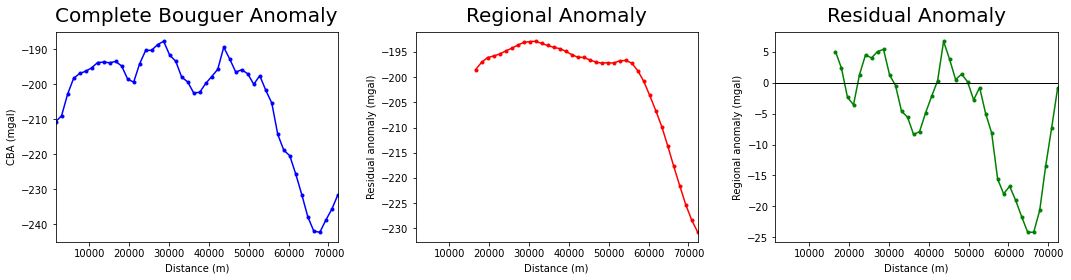

In [24]:
# Plot separated anomalies
Slice = EW1_result

distance = Slice.Distance
reg = Slice.Regional
res = Slice.Residual
CBA = Slice.CBA

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(distance, CBA, '.-', color='blue')
plt.title('Complete Bouguer Anomaly', size=20, pad=10)
plt.xlabel('Distance (m)'); plt.ylabel('CBA (mgal)')
plt.xlim(min(distance), max(distance))

plt.subplot(1,3,2)
plt.plot(distance, reg, '.-', color='red')
plt.title('Regional Anomaly', size=20, pad=10)
plt.xlabel('Distance (m)'); plt.ylabel('Residual anomaly (mgal)')
plt.xlim(min(distance), max(distance))

plt.subplot(1,3,3)
plt.plot(distance, res, '.-', color='green')
plt.axhline(0, linewidth=1, color='black')
plt.title('Residual Anomaly', size=20, pad=10)
plt.xlabel('Distance (m)'); plt.ylabel('Regional anomaly (mgal)')
plt.xlim(min(distance), max(distance))

plt.tight_layout(1.1)
plt.show()

Transform 1D slices back to 2D map and gridding it to map.

In [25]:
# Concatenate all dataframes of slices
results = pd.concat((SWNE_result, SENW_result, EW1_result,
                     EW2_result, EW3_result)).reset_index(drop=True)

# Gridding x and y
xi = np.linspace(min(utm_x), max(utm_x), 50)
yi = np.linspace(min(utm_y), max(utm_y), 50)
xi, yi = np.meshgrid(xi, yi)

x, y = results["UTM X"].values, results["UTM Y"].values
CBA, reg, res = results.CBA.values, results.Regional.values, results.Residual.values

zi_CBA = griddata((x,y),CBA,(xi,yi))
zi_reg = griddata((x,y),reg,(xi,yi))
zi_res = griddata((x,y),res,(xi,yi))

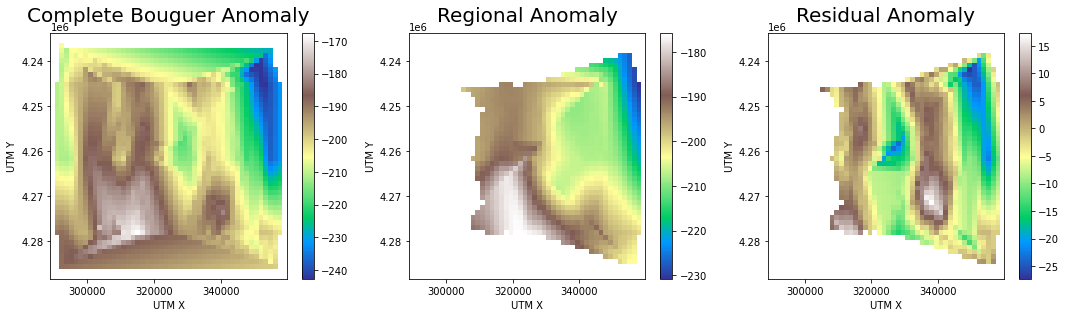

In [28]:
# Min max coordinates
xmin, xmax = min(x), max(x)
ymin, ymax = min(y), max(y)

# Grid map
plt.figure(figsize=(15,4.5))

plt.subplot(1,3,1)
plt.imshow(zi_CBA, aspect='auto', extent=(xmin,xmax,ymax,ymin), cmap='terrain')
plt.title('Complete Bouguer Anomaly', size=20, pad=12)
plt.xlabel('UTM X'); plt.ylabel('UTM Y')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(zi_reg, aspect='auto', extent=(xmin,xmax,ymax,ymin), cmap='terrain')
plt.title('Regional Anomaly', size=20, pad=12)
plt.xlabel('UTM X'); plt.ylabel('UTM Y')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(zi_res, aspect='auto', extent=(xmin,xmax,ymax,ymin), cmap='terrain')
plt.title('Residual Anomaly', size=20, pad=12)
plt.xlabel('UTM X'); plt.ylabel('UTM Y')
plt.colorbar()

plt.tight_layout(1.03)
plt.show()

We can see that parts of the anomalies are lost because in this 1D FFT method we use Moving Average. In another notebook, we use another method, Second Vertical Derivative, to separate the anomalies directly from the 2D data.